# Decision Trees and Hyperparameters tuning

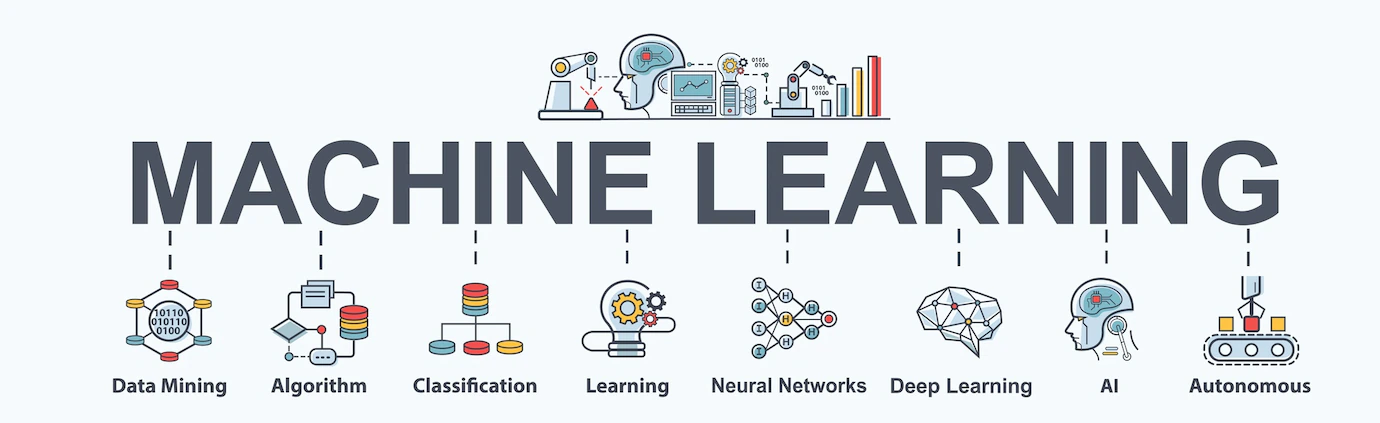

# Importing Libraries

In [1]:
import opendatasets as od
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib
#import jovian
import os
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

In [2]:
raw_df = pd.read_csv('weatherAUS.csv')
raw_df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [3]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [4]:
raw_df.dropna(subset=['RainTomorrow'], inplace=True)

## Preparing the Data for Training

We'll perform the following steps to prepare the dataset for training:

1. Create a train/test/validation split
2. Identify input and target columns
3. Identify numeric and categorical columns
4. Impute (fill) missing numeric values
5. Scale numeric values to the $(0, 1)$ range
6. Encode categorical columns to one-hot vectors

### Training, Validation and Test Sets

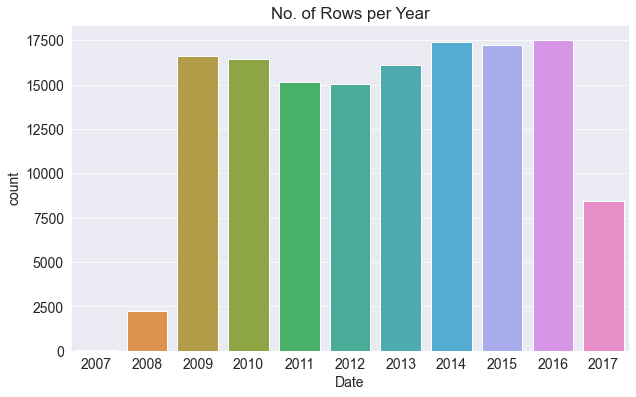

In [5]:
plt.title('No. of Rows per Year')
sns.countplot(x=pd.to_datetime(raw_df.Date).dt.year);

While working with chronological data, it's often a good idea to separate the training, validation and test sets with time, so that the model is trained on data from the past and evaluated on data from the future.

We'll use the data till 2014 for the training set, data from 2015 for the validation set, and the data from 2016 & 2017 for the test set.  

In [6]:
year = pd.to_datetime(raw_df.Date).dt.year
train_df = raw_df[year < 2015]
val_df = raw_df[year == 2015]
test_df = raw_df[year > 2015]

In [7]:
print('train_df.shape :', train_df.shape)
print('val_df.shape :', val_df.shape)
print('test_df.shape :', test_df.shape)

train_df.shape : (98988, 23)
val_df.shape : (17231, 23)
test_df.shape : (25974, 23)


### Input and Target Columns

Let's identify the input and target columns.

In [8]:
input_cols = list(train_df.columns)[1:-1]
target_col = 'RainTomorrow'

In [9]:
train_inputs = train_df[input_cols].copy()
train_targets = train_df[target_col].copy()

In [10]:
val_inputs = val_df[input_cols].copy()
val_targets = val_df[target_col].copy()

In [11]:
test_inputs = test_df[input_cols].copy()
test_targets = test_df[target_col].copy()

In [12]:
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()
#numeric_cols
#categorical_cols

In [13]:
numeric_cols

['MinTemp',
 'MaxTemp',
 'Rainfall',
 'Evaporation',
 'Sunshine',
 'WindGustSpeed',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm',
 'Cloud9am',
 'Cloud3pm',
 'Temp9am',
 'Temp3pm']

In [14]:
categorical_cols

['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']

### Imputing missing numeric values

In [15]:
from sklearn.impute import SimpleImputer

In [16]:
imputer = SimpleImputer(strategy = 'mean').fit(raw_df[numeric_cols])


In [17]:
train_inputs[numeric_cols] = imputer.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = imputer.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = imputer.transform(test_inputs[numeric_cols])

In [18]:
test_inputs[numeric_cols].isna().sum()

MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
dtype: int64

### Scaling Numeric Features

In [19]:
from sklearn.preprocessing import MinMaxScaler

In [20]:
scaler = MinMaxScaler().fit(raw_df[numeric_cols])

In [21]:
train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

In [22]:
val_inputs.describe().loc[['min', 'max']]

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
min,0.007075,0.030246,0.000000,0.000000,0.0,0.007752,0.000000,0.000000,0.04,0.0,0.125620,0.0816,0.000000,0.000000,0.021097,0.026871
max,0.952830,0.948960,0.666307,0.485517,1.0,1.000000,0.669231,0.850575,1.00,1.0,0.971901,0.9632,0.888889,0.888889,0.943038,0.925144


### Encoding Categorical Data

In [23]:
from sklearn.preprocessing import OneHotEncoder

In [24]:
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore').fit(raw_df[categorical_cols])

In [25]:
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
encoded_cols

['Location_Adelaide',
 'Location_Albany',
 'Location_Albury',
 'Location_AliceSprings',
 'Location_BadgerysCreek',
 'Location_Ballarat',
 'Location_Bendigo',
 'Location_Brisbane',
 'Location_Cairns',
 'Location_Canberra',
 'Location_Cobar',
 'Location_CoffsHarbour',
 'Location_Dartmoor',
 'Location_Darwin',
 'Location_GoldCoast',
 'Location_Hobart',
 'Location_Katherine',
 'Location_Launceston',
 'Location_Melbourne',
 'Location_MelbourneAirport',
 'Location_Mildura',
 'Location_Moree',
 'Location_MountGambier',
 'Location_MountGinini',
 'Location_Newcastle',
 'Location_Nhil',
 'Location_NorahHead',
 'Location_NorfolkIsland',
 'Location_Nuriootpa',
 'Location_PearceRAAF',
 'Location_Penrith',
 'Location_Perth',
 'Location_PerthAirport',
 'Location_Portland',
 'Location_Richmond',
 'Location_Sale',
 'Location_SalmonGums',
 'Location_Sydney',
 'Location_SydneyAirport',
 'Location_Townsville',
 'Location_Tuggeranong',
 'Location_Uluru',
 'Location_WaggaWagga',
 'Location_Walpole',
 'Locat

In [26]:
train_inputs = train_inputs.drop(categorical_cols, axis=1)
val_inputs = val_inputs.drop(categorical_cols, axis=1)
test_inputs = test_inputs.drop(categorical_cols, axis=1)

In [27]:
X_train = train_inputs[numeric_cols]
X_val = val_inputs[numeric_cols]
X_test = test_inputs[numeric_cols]

### Training

We can use `DecisionTreeClassifier` from `sklearn.tree` to train a decision tree.

In [28]:
from sklearn.tree import DecisionTreeClassifier

In [29]:
model = DecisionTreeClassifier(random_state=42)

In [30]:
%%time
model.fit(X_train, train_targets)

Wall time: 2.09 s


DecisionTreeClassifier(random_state=42)

### Evaluation

Let's evaluate the decision tree using the accuracy score.

In [31]:
from sklearn.metrics import accuracy_score, confusion_matrix


In [32]:
train_preds = model.predict(X_train)


In [33]:
train_preds

array(['No', 'No', 'No', ..., 'No', 'No', 'No'], dtype=object)

In [36]:
pd.value_counts(train_preds)


No     76707
Yes    22281
dtype: int64

The decision tree also returns probabilities for each prediction.

In [37]:
train_probs = model.predict_proba(X_train)

In [38]:
train_probs

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

Seems like the decision tree is quite confident about its predictions.

Let's check the accuracy of its predictions.

In [39]:
accuracy_score(train_targets, train_preds)

0.9999797955307714

The training set accuracy is close to 100%! But we can't rely solely on the training set accuracy, we must evaluate the model on the validation set too. 

We can make predictions and compute accuracy in one step using `model.score`

In [40]:
model.score(X_val, val_targets)

0.7856189426034472

Although the training accuracy is 100%, the accuracy on the validation set is just about 79%, which is only marginally better then always predicting "No". 

In [41]:
val_targets.value_counts()/len(val_targets)

No     0.788289
Yes    0.211711
Name: RainTomorrow, dtype: float64

It appears that the model has learned the training examples perfect, and doesn't generalize well to previously unseen examples. This phenomenon is called "overfitting", and reducing overfitting is one of the most important parts of any machine learning project.

### Visualization

We can visualize the decision tree _learned_ from the training data.

In [42]:
from sklearn.tree import plot_tree, export_text

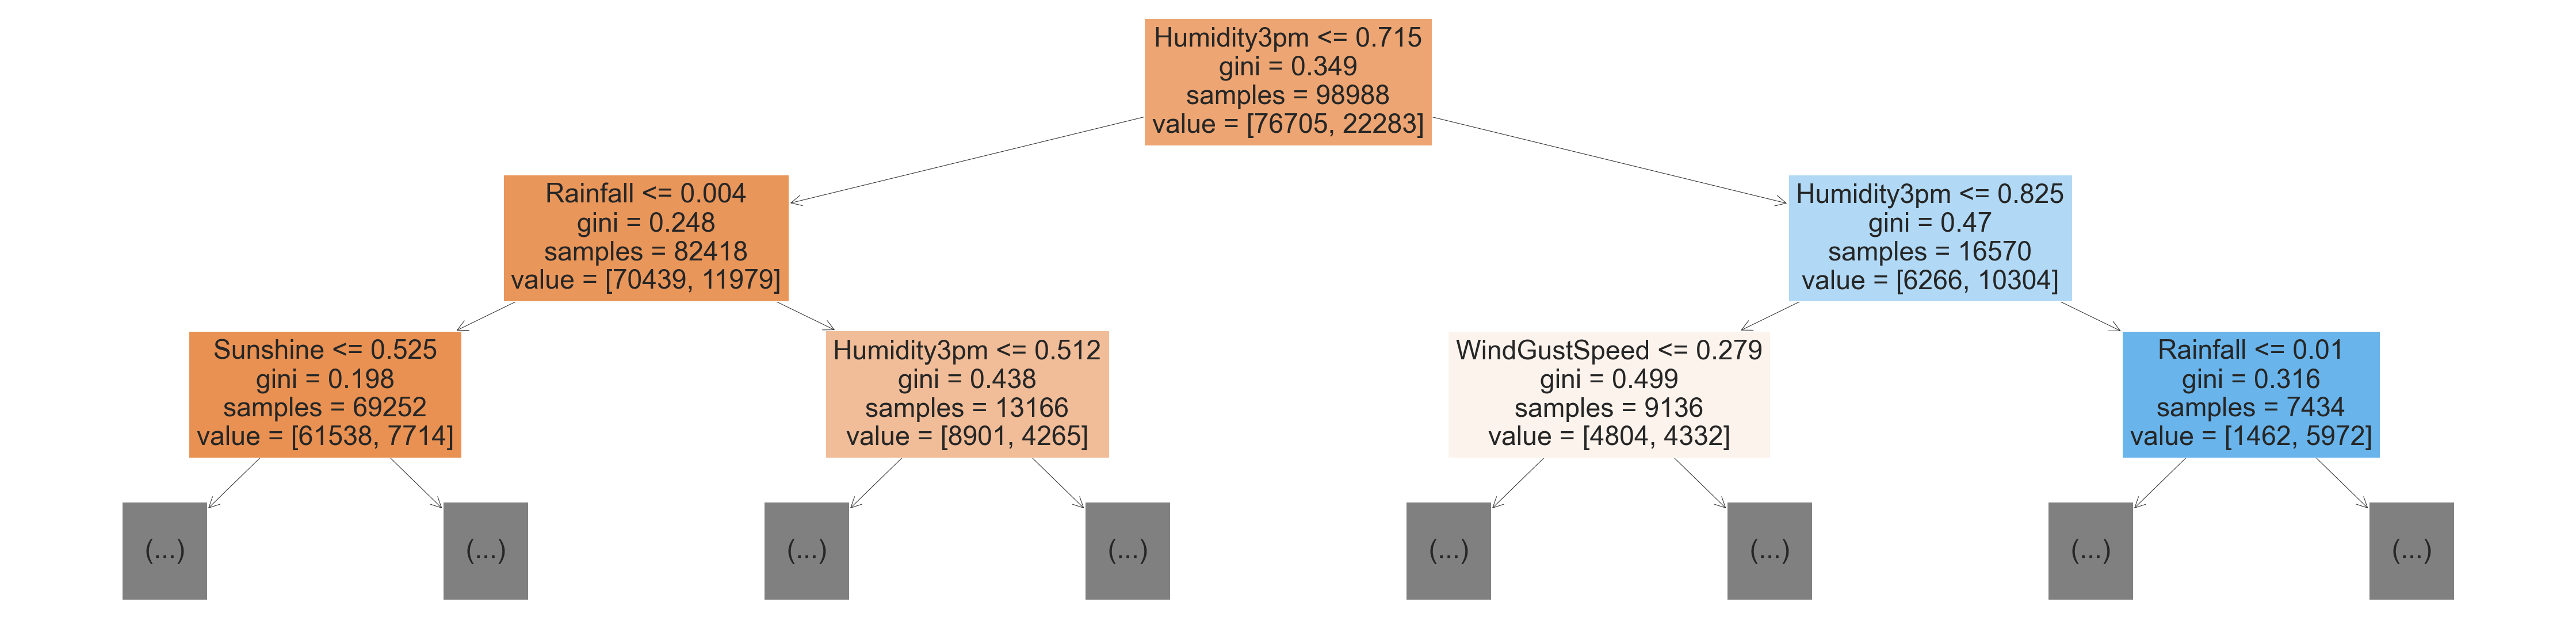

In [43]:
plt.figure(figsize=(80,20))
plot_tree(model, feature_names=X_train.columns, max_depth=2, filled=True);

Can you see how the model classifies a given input as a series of decisions? The tree is truncated here, but following any path from the root node down to a leaf will result in "Yes" or "No". Do you see how a decision tree differs from a logistic regression model?


**How a Decision Tree is Created**

Note the `gini` value in each box. This is the loss function used by the decision tree to decide which column should be used for splitting the data, and at what point the column should be split. A lower Gini index indicates a better split. A perfect split (only one class on each side) has a Gini index of 0. 

For a mathematical discussion of the Gini Index, watch this video: https://www.youtube.com/watch?v=-W0DnxQK1Eo . It has the following formula:

<img src="https://i.imgur.com/CSC0gAo.png" width="240">

Conceptually speaking, while training the models evaluates all possible splits across all possible columns and picks the best one. Then, it recursively performs an optimal split for the two portions. In practice, however, it's very inefficient to check all possible splits, so the model uses a heuristic (predefined strategy) combined with some randomization.

The iterative approach of the machine learning workflow in the case of a decision tree involves growing the tree layer-by-layer:

<img src="https://www.deepnetts.com/blog/wp-content/uploads/2019/02/SupervisedLearning.png" width="480">


Let's check the depth of the tree that was created.

In [44]:
model.tree_.max_depth


45

We can also display the tree as text, which can be easier to follow for deeper trees.

In [45]:
tree_text = export_text(model, max_depth=10, feature_names=list(X_train.columns))
print(tree_text[:5000])

|--- Humidity3pm <= 0.72
|   |--- Rainfall <= 0.00
|   |   |--- Sunshine <= 0.52
|   |   |   |--- Pressure3pm <= 0.58
|   |   |   |   |--- WindGustSpeed <= 0.36
|   |   |   |   |   |--- Humidity3pm <= 0.28
|   |   |   |   |   |   |--- Cloud9am <= 0.61
|   |   |   |   |   |   |   |--- WindSpeed3pm <= 0.07
|   |   |   |   |   |   |   |   |--- Cloud3pm <= 0.36
|   |   |   |   |   |   |   |   |   |--- class: No
|   |   |   |   |   |   |   |   |--- Cloud3pm >  0.36
|   |   |   |   |   |   |   |   |   |--- class: Yes
|   |   |   |   |   |   |   |--- WindSpeed3pm >  0.07
|   |   |   |   |   |   |   |   |--- Pressure3pm <= 0.58
|   |   |   |   |   |   |   |   |   |--- MinTemp <= 0.33
|   |   |   |   |   |   |   |   |   |   |--- class: Yes
|   |   |   |   |   |   |   |   |   |--- MinTemp >  0.33
|   |   |   |   |   |   |   |   |   |   |--- Pressure3pm <= 0.51
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 5
|   |   |   |   |   |   |   |   |   |   |--- Pressure3pm >  

### Feature Importance

Based on the gini index computations, a decision tree assigns an "importance" value to each feature. These values can be used to interpret the results given by a decision tree.

In [46]:
model.feature_importances_


array([0.05131158, 0.04787139, 0.06675741, 0.03467603, 0.06036243,
       0.06528742, 0.04007495, 0.04067856, 0.05209608, 0.26964261,
       0.05258127, 0.07803128, 0.02007274, 0.02440305, 0.0481023 ,
       0.04805091])

In [47]:
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

In [48]:
importance_df.head(10)


,feature,importance
9,Humidity3pm,0.269643
11,Pressure3pm,0.078031
2,Rainfall,0.066757
5,WindGustSpeed,0.065287
4,Sunshine,0.060362
10,Pressure9am,0.052581
8,Humidity9am,0.052096
0,MinTemp,0.051312
14,Temp9am,0.048102
15,Temp3pm,0.048051


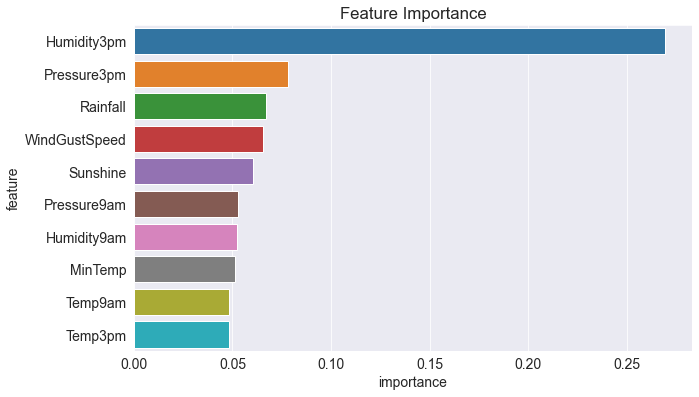

In [49]:
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');

## Hyperparameter Tuning and Overfitting

As we saw in the previous section, our decision tree classifier memorized all training examples, leading to a 100% training accuracy, while the validation accuracy was only marginally better than a dumb baseline model. This phenomenon is called overfitting, and in this section, we'll look at some strategies for reducing overfitting. The process of reducing overfitting is known as _regularlization_.


The `DecisionTreeClassifier` accepts several arguments, some of which can be modified to reduce overfitting.

In [50]:
?DecisionTreeClassifier

These arguments are called hyperparameters because they must be configured manually (as opposed to the parameters within the model which are _learned_ from the data. We'll explore a couple of hyperparameters:

- `max_depth`
- `max_leaf_nodes`

### `max_depth`

By reducing the maximum depth of the decision tree, we can prevent the tree from memorizing all training examples, which may lead to better generalization

In [51]:
model = DecisionTreeClassifier(max_depth=3, random_state=42)

In [52]:
model.fit(X_train, train_targets)

DecisionTreeClassifier(max_depth=3, random_state=42)

We can compute the accuracy of the model on the training and validation sets using `model.score`

In [53]:
model.score(X_train, train_targets)

0.8291308037337859

Let's experiment with different depths using a helper function.

In [54]:
def max_depth_error(md):
    model = DecisionTreeClassifier(max_depth=md, random_state=42)
    model.fit(X_train, train_targets)
    train_acc = 1 - model.score(X_train, train_targets)
    val_acc = 1 - model.score(X_val, val_targets)
    return {'Max Depth': md, 'Training Error': train_acc, 'Validation Error': val_acc}

In [55]:
%%time
errors_df = pd.DataFrame([max_depth_error(md) for md in range(1, 21)])

Wall time: 21.4 s


In [56]:
errors_df

,Max Depth,Training Error,Validation Error
0,1,0.184315,0.177935
1,2,0.179547,0.172712
2,3,0.170869,0.166560
3,4,0.165707,0.164355
4,5,0.160615,0.159132
5,6,0.156413,0.157739
6,7,0.152877,0.155592
7,8,0.147321,0.157739
8,9,0.142027,0.156230
9,10,0.135158,0.159132


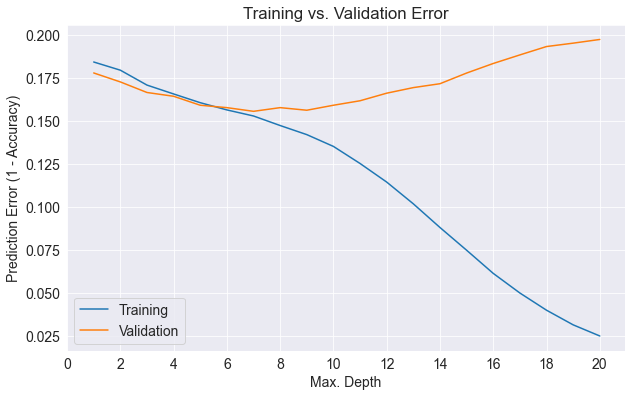

In [57]:
plt.figure()
plt.plot(errors_df['Max Depth'], errors_df['Training Error'])
plt.plot(errors_df['Max Depth'], errors_df['Validation Error'])
plt.title('Training vs. Validation Error')
plt.xticks(range(0,21, 2))
plt.xlabel('Max. Depth')
plt.ylabel('Prediction Error (1 - Accuracy)')
plt.legend(['Training', 'Validation'])

This is a common pattern you'll see with all machine learning algorithms:

<img src="https://i.imgur.com/EJCrSZw.png" width="480">


In [58]:
model = DecisionTreeClassifier(max_depth=7, random_state=42).fit(X_train, train_targets)
model.score(X_val, val_targets)

0.8444083338169578

### `max_leaf_nodes`

Another way to control the size of complexity of a decision tree is to limit the number of leaf nodes. This allows branches of the tree to have varying depths. 

In [59]:
model = DecisionTreeClassifier(max_leaf_nodes=128, random_state=42)

In [60]:
model.fit(X_train, train_targets)

DecisionTreeClassifier(max_leaf_nodes=128, random_state=42)

In [61]:
model.score(X_train, train_targets)

0.8495070109508224

In [62]:
model.score(X_val, val_targets)

0.8442922639428936

In [63]:
model.tree_.max_depth

11

## Training a Random Forest

While tuning the hyperparameters of a single decision tree may lead to some improvements, a much more effective strategy is to combine the results of several decision trees trained with slightly different parameters. This is called a random forest model. 

The key idea here is that each decision tree in the forest will make different kinds of errors, and upon averaging, many of their errors will cancel out. This idea is also commonly known as the "wisdom of the crowd":

<img src="https://i.imgur.com/4Dg0XK4.png" width="480">

A random forest works by averaging/combining the results of several decision trees:

<img src="https://1.bp.blogspot.com/-Ax59WK4DE8w/YK6o9bt_9jI/AAAAAAAAEQA/9KbBf9cdL6kOFkJnU39aUn4m8ydThPenwCLcBGAsYHQ/s0/Random%2BForest%2B03.gif" width="640">


We'll use the `RandomForestClassifier` class from `sklearn.ensemble`.

In [64]:
from sklearn.ensemble import RandomForestClassifier

In [65]:
model = RandomForestClassifier(n_jobs=-1, random_state=42)

`n_jobs` allows the random forest to use mutiple parallel workers to train decision trees, and `random_state=42` ensures that the we get the same results for each execution.

In [66]:
%%time
model.fit(X_train, train_targets)

Wall time: 4.67 s


RandomForestClassifier(n_jobs=-1, random_state=42)

In [67]:
model.score(X_train, train_targets)

0.9999494888269285

In [68]:
model.score(X_val, val_targets)

0.8536939237420927

Once again, the training accuracy is almost 100%, but this time the validation accuracy is much better. In fact, it is better than the best single decision tree we had trained so far. Do you see the power of random forests?

This general technique of combining the results of many models is called "ensembling", it works because most errors of individual models cancel out on averaging. Here's what it looks like visually:

<img src="https://i.imgur.com/qJo8D8b.png" width="640">


We can also look at the probabilities for the predictions. The probability of a class is simply the fraction of trees which that predicted the given class.

In [69]:
train_probs = model.predict_proba(X_train)
train_probs

array([[0.95, 0.05],
       [0.98, 0.02],
       [0.99, 0.01],
       ...,
       [0.99, 0.01],
       [0.99, 0.01],
       [0.95, 0.05]])

We can can access individual decision trees using `model.estimators_`

In [70]:
model.estimators_[0]

DecisionTreeClassifier(max_features='sqrt', random_state=1608637542)

In [71]:
len(model.estimators_)

100

Just like decision tree, random forests also assign an "importance" to each feature, by combining the importance values from individual trees.

In [72]:
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

In [73]:
importance_df.head(10)

,feature,importance
9,Humidity3pm,0.204808
2,Rainfall,0.076817
11,Pressure3pm,0.069905
4,Sunshine,0.069748
10,Pressure9am,0.065201
5,WindGustSpeed,0.063089
8,Humidity9am,0.059016
0,MinTemp,0.055477
15,Temp3pm,0.055412
1,MaxTemp,0.053622


## Hyperparameter Tuning with Random Forests

Just like decision trees, random forests also have several hyperparameters. In fact many of these hyperparameters are applied to the underlying decision trees. 

Let's study some the hyperparameters for random forests. You can learn more about them here: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [74]:
?RandomForestClassifier

Let's create a base model with which we can compare models with tuned hyperparameters.

In [75]:
base_model = RandomForestClassifier(random_state=42, n_jobs=-1).fit(X_train, train_targets)

In [76]:
base_train_acc = base_model.score(X_train, train_targets)
base_val_acc = base_model.score(X_val, val_targets)

In [77]:
base_accs = base_train_acc, base_val_acc
base_accs

(0.9999494888269285, 0.8536939237420927)

### `n_estimators`

This argument controls the number of decision trees in the random forest. The default value is 100. For larger datasets, it helps to have a greater number of estimators. As a general rule, try to have as few estimators as needed. 


**10 estimators**

In [78]:
model = RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=10)

In [79]:
model.fit(X_train, train_targets)

RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=42)

In [80]:
model.score(X_train, train_targets), model.score(X_val, val_targets)


(0.9871499575706146, 0.8438860193836689)

In [81]:
base_accs

(0.9999494888269285, 0.8536939237420927)

**500 estimators**

In [82]:
model = RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=500)
model.fit(X_train, train_targets)

RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)

In [83]:
model.score(X_train, train_targets)

0.9999797955307714

In [84]:
model.score(X_val, val_targets)

0.8546224827346063

In [85]:
base_accs

(0.9999494888269285, 0.8536939237420927)

### `max_depth` and `max_leaf_nodes`

These arguments are passed directly to each decision tree, and control the maximum depth and max. no leaf nodes of each tree respectively. By default, no maximum depth is specified, which is why each tree has a training accuracy of 100%. You can specify a `max_depth` to reduce overfitting.

<img src="https://i.imgur.com/EJCrSZw.png" width="480">

Let's define a helper function `test_params` to make it easy to test hyperparameters.

In [86]:
def test_params(**params):
    model = RandomForestClassifier(random_state=42, n_jobs=-1, **params).fit(X_train, train_targets)
    return model.score(X_train, train_targets), model.score(X_val, val_targets)

Let's test a few values of `max_depth` and `max_leaf_nodes`.

In [87]:
test_params(max_depth=5)

(0.8425667757708005, 0.8429574603911555)

In [88]:
test_params(max_leaf_nodes=2**20)

(0.9999393865923142, 0.8534617839939643)

### `max_features`

Instead of picking all features (columns) for every split, we can specify that only a fraction of features be chosen randomly to figure out a split.

<img src="https://i.imgur.com/FXGWMDY.png" width="720">

Notice that the default value `auto` causes only $\sqrt{n}$ out of total features ( $n$ ) to be chosen randomly at each split. This is the reason each decision tree in the forest is different. While it may seem counterintuitive, choosing all features for every split of every tree will lead to identical trees, so the random forest will not generalize well. 

In [89]:
test_params(max_features='log2')

(0.9999494888269285, 0.8536939237420927)

In [90]:
test_params(max_features=3)

(0.9999494888269285, 0.8529394695606756)

### `min_samples_split` and `min_samples_leaf`

By default, the decision tree classifier tries to split every node that has 2 or more. You can increase the values of these arguments to change this behavior and reduce overfitting, especially for very large datasets.

In [91]:
test_params(min_samples_split=3, min_samples_leaf=2)

(0.9832504950094961, 0.8545644477975741)

### `min_impurity_decrease`

This argument is used to control the threshold for splitting nodes. A node will be split if this split induces a decrease of the impurity (Gini index) greater than or equal to this value. It's default value is 0, and you can increase it to reduce overfitting.


In [92]:
test_params(min_impurity_decrease=1e-7)

(0.9999393865923142, 0.855144797167895)

### `bootstrap`, `max_samples` 

By default, a random forest doesn't use the entire dataset for training each decision tree. Instead it applies a technique called bootstrapping. For each tree, rows from the dataset are picked one by one randomly, with replacement i.e. some rows may not show up at all, while some rows may show up multiple times.


<img src="https://i.imgur.com/W8UGaEA.png" width="640">

Bootstrapping helps the random forest generalize better, because each decision tree only sees a fraction of th training set, and some rows randomly get higher weightage than others.

In [93]:
test_params(bootstrap=False)

(0.9999797955307714, 0.8533457141199002)

In [94]:
base_accs

(0.9999494888269285, 0.8536939237420927)

When bootstrapping is enabled, you can also control the number or fraction of rows to be considered for each bootstrap using `max_samples`. This can further generalize the model.

<img src="https://i.imgur.com/rsdrL1W.png" width="640">

In [95]:
test_params(max_samples=0.9)

(0.9997373419000283, 0.853868028553189)

In [96]:
base_accs

(0.9999494888269285, 0.8536939237420927)

### `class_weight`

In [97]:
model.classes_

array(['No', 'Yes'], dtype=object)

In [98]:
test_params(class_weight='balanced')

(0.9999595910615429, 0.8525332250014509)

In [99]:
test_params(class_weight={'No': 1, 'Yes': 2})

(0.9999393865923142, 0.8520689455051941)

### Putting it together

Let's train a random forest with customized hyperparameters based on our learnings. Of course, different hyperpraams

In [100]:
model.fit(X_train, train_targets)

RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)

In [101]:
model.score(X_train, train_targets), model.score(X_val, val_targets)

(0.9999797955307714, 0.8546224827346063)

We've increased the accuracy from 84.5% with a single decision tree to 85.7% with a well-tuned random forest. Depending on the dataset and the kind of problem, you may or may not a see a significant improvement with hyperparameter tuning. 

This could be due to any of the following reasons:

- We may not have found the right mix of hyperparameters to regularize (reduce overfitting) the model properly, and we should keep trying to improve the model.

- We may have reached the limits of the modeling technique we're currently using (Random Forests), and we should try another modeling technique e.g. gradient boosting.

- We may have reached the limits of what we can predict using the given amount of data, and we may need more data to improve the model.

- We may have reached the limits of how well we can predict whether it will rain tomorrow using the given weather measurements, and we may need more features (columns) to further improve the model. In many cases, we can also generate new features using existing features (this is called feature engineering).

- Whether it will rain tomorrow may be an inherently random or chaotic phenomenon which simply cannot be predicted beyond a certain accuracy any amount of data for any number of weather measurements with any modeling technique.  

Remember that ultimately all models are wrong, but some are useful. If you can rely on the model we've created today to make a travel decision for tomorrow, then the model is useful, even though it may sometimes be wrong.

### Strategy for Tuning Hyperparameters

Here's a good strategy for tuning hyperparameters:

1. Tune the most important/impactful hyperparameter first e.g. n_estimators

2. With the best value of the first hyperparameter, tune the next most impactful hyperparameter

3. And so on, keep training the next most impactful parameters with the best values for previous parameters...

4. Then, go back to the top and further tune each parameter again for further marginal gains

Keep your ideas and experiments organized using an experiment tracking sheet: https://bit.ly/mltrackingsheet


Your first objective should be make the training loss as low as possible (even if the validation loss is very large), and then try to regularize the model to slowly decrease the valiadation loss while increasing the training loss.


Hyperparameter tuning is more art than science, unfortunately. Try to get a feel for how the parameters interact with each other based on your understanding of the parameter

Finally, let's also compute the accuracy of our model on the test set.

In [102]:
model.score(X_test, test_targets)

0.8424578424578425

## Making Predictions on New Inputs

Let's define a helper function to make predictions on new inputs.

In [103]:
def predict_input(model, single_input):
    input_df = pd.DataFrame([single_input])
    input_df[numeric_cols] = imputer.transform(input_df[numeric_cols])
    input_df[numeric_cols] = scaler.transform(input_df[numeric_cols])
    input_df[encoded_cols] = encoder.transform(input_df[categorical_cols])
    X_input = input_df[numeric_cols + encoded_cols]
    pred = model.predict(X_input)[0]
    prob = model.predict_proba(X_input)[0][list(model.classes_).index(pred)]
    return pred, prob

In [104]:
new_input = {'Date': '2021-06-19',
             'Location': 'Launceston',
             'MinTemp': 23.2,
             'MaxTemp': 33.2,
             'Rainfall': 10.2,
             'Evaporation': 4.2,
             'Sunshine': np.nan,
             'WindGustDir': 'NNW',
             'WindGustSpeed': 52.0,
             'WindDir9am': 'NW',
             'WindDir3pm': 'NNE',
             'WindSpeed9am': 13.0,
             'WindSpeed3pm': 20.0,
             'Humidity9am': 89.0,
             'Humidity3pm': 58.0,
             'Pressure9am': 1004.8,
             'Pressure3pm': 1001.5,
             'Cloud9am': 8.0,
             'Cloud3pm': 5.0,
             'Temp9am': 25.7,
             'Temp3pm': 33.0,
             'RainToday': 'Yes'}

In [113]:
#predict_input(model, new_input)

## Saving and Loading Trained Models

We can save the parameters (weights and biases) of our trained model to disk, so that we needn't retrain the model from scratch each time we wish to use it. Along with the model, it's also important to save imputers, scalers, encoders and even column names. Anything that will be required while generating predictions using the model should be saved.

We can use the `joblib` module to save and load Python objects on the disk. 

In [114]:
import joblib

In [115]:
aussie_rain = {
    'model': model,
    'imputer': imputer,
    'scaler': scaler,
    'encoder': encoder,
    'input_cols': input_cols,
    'target_col': target_col,
    'numeric_cols': numeric_cols,
    'categorical_cols': categorical_cols,
    'encoded_cols': encoded_cols
}

In [116]:
joblib.dump(aussie_rain, 'aussie_rain.joblib')

['aussie_rain.joblib']

The object can be loaded back using `joblib.load`

In [117]:
aussie_rain2 = joblib.load('aussie_rain.joblib')

In [118]:
test_preds2 = aussie_rain2['model'].predict(X_test)
accuracy_score(test_targets, test_preds2)

0.8424578424578425